<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Webscrapping: Modeling Notebook

_Authors: Patrick Wales-Dinan_

---

This lab was incredibly challenging. We had to extensively clean a date set that was missing a lot of values and had TONS of categorical data. Then we had to decide what features to use to model that data. After that we had to build and fit the models making decisions like whether to use polynomial features, dummy variables etc, log scaling features or log scaling the depended variable.

After that we had to re run our model over and over again, looking at the different values of $\beta$ and seeing if they were contributing to the predictive power of the model. We had to decide if we should throw those values out or if we should leave them. We also had to make judgement calls to see if our model appeared to be over fitting or suffering from bias. 

## Contents:
- [Data Import](#Data-Import)
- [Baseline Accuracy](#Calculate-the-Baseline-Accuracy)
- [Data Modeling](#Model-Our-Data)
- [Data Exploration](#Data-Exploration)
- [Cleaning the Data and Modifying the Data](#Cleaning-&-Creating-the-Data-Set)
- [Modeling the Data](#Modeling-the-Data)
- [Model Analysis](#Analyzing-the-model)

Please visit the Graphs & Relationships notebook for additional visuals: Notebook - [Here](/Users/pwalesdi/Desktop/GA/GA_Project_2/Project_2_Graphs_&_Relationships.ipynb)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy
from os import path
import scipy
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import stop_words 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Import

In [2]:
# Read in our data from the reddit csv
df_reddit = pd.read_csv('./reddit.csv')

## Calculate the Baseline Accuracy

In [3]:
# Getting our baseline accuracy :: So 0.51 is the baseline accuracy for 0 (TX subreddit) and 0.48 for 1 (CA subreddit)
df_reddit['is_ca'] = df_reddit['ca']
df_reddit['is_ca'].value_counts(normalize=True)

0    0.511458
1    0.488542
Name: is_ca, dtype: float64

## Model Our Data

In [4]:
# Defining our X & y variables
X = df_reddit['title']
y = df_reddit['is_ca']

In [ ]:
# Deciding which words to remove via stop words
stop_words = ['to', 'the', 'in', 'of', 'for', 'and', 'on', 'is', 'it', 
              'with', 'what', 'about', 'are', 'as', 'from', 'at', 'will', 
              'that', 'says', 'by', 'be', 'this', 'can', 'has', 'how', 
              'california', 'texas']
# Setting up our hyperparameters to pass through our pipeline
pipe_params = {
    'vec' : [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features': [1500, 1600, 1700],
    'vec__min_df': [2, 3],
    'vec__max_df': [0.4, 0.5],
    'vec__ngram_range': [(1,2), (1,1)],
    'vec__stop_words': [frozenset(stop_words)],
    'model' : [LogisticRegression(), 
               LogisticRegression(penalty='l1', solver='liblinear'), 
               LogisticRegression(penalty='l2', solver='liblinear'), 
               MultinomialNB(alpha=1.1),
               RandomForestClassifier(n_estimators=1500),
#                DecisionTreeClassifier()
              ],
}

# Defining a function to do our model analysis. This function takes in X, y, and any pipe parameters
def model_analysis(X, y, **pipe_params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    pipe = Pipeline([
            ('vec', CountVectorizer()),
            ('model', LogisticRegression())])

    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, verbose=1, n_jobs=2)
    gs.fit(X_train, y_train)

    print(f' Best Parameters: {gs.best_params_}')
    print('')
    print(f' Cross Validation Accuracy Score: {gs.best_score_}')
    print(f' Training Data Accuracy Score: {gs.score(X_train, y_train)}')
    print(f' Testing Data Accuracy Score: {gs.score(X_test, y_test)}')

In [ ]:
model_analysis(X, y, **pipe_params)

## Data Exploration
### What is driving our model and what features are important

Here I will use a countvectorizer and a logistic regression model to further examine our ß values for each coefficient 

In [34]:
X = df_reddit['title']
y = df_reddit['is_ca']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=79)

stop_words = ['to', 'the', 'in', 'of', 'for', 'and', 'on', 'is', 'it', 'with', 'what', 'about', 'are', 'as', 'from', 'at', 'will', 'that', 'says', 'by', 'be', 'this', 'can', 'has', 'how', 'up', 'not', 'but', 'they']
vectorizer = CountVectorizer(tokenizer = None,
                            preprocessor = None,
                            stop_words = frozenset(stop_words),
                            max_features = 1500,
                            ngram_range= (1,2),
                            analyzer = 'word', 
                            min_df=3) 
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_train_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
X_test_df = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names())
y_train_df = pd.DataFrame(y_train)


### What are our most common features in the training set

In [ ]:
X_train_df.sum().sort_values(ascending=False).head(10)

In [ ]:
color = cm.plasma_r(np.linspace(.9,.05, 30))
plt.figure(figsize=(15,10))
X_train_df.sum().sort_values(ascending=False).head(30).plot.barh(color=color)
plt.yticks(rotation=15)
plt.title("The 30 Most Common Words in the Training Set", fontsize=22)
plt.xlabel("Number of Occurrences", fontsize=15)
plt.ylabel("Most Common Words", fontsize=15)
plt.show()


### What are our most common features in the test set

In [ ]:
X_test_df.sum().sort_values(ascending=False).head(10)

In [ ]:
color2 = cm.Spectral_r(np.linspace(.9,.1, 30))
plt.figure(figsize=(15,10))
X_test_df.sum().sort_values(ascending=False).head(30).plot.barh(color=color2)
plt.yticks(rotation=15)
plt.title("The 30 Most Common Words in the Testing Set", fontsize=22)
plt.xlabel("Number of Occurrences", fontsize=15)
plt.ylabel("Most Common Words", fontsize=15)
plt.show()


In [ ]:
# y_train_df = y_train_df.reset_index()
# corr = pd.concat([X_train_df, y_train_df], axis=1)
# corr.corr()[['is_ca']].sort_values('is_ca', ascending=False).head(10)

In [ ]:
# h_map = corr[['is_ca', 'newsom', 'gavin', 'ca', 'housing', 'los angeles', 'prop', 'proposition', 'wildfires', 'border', 'migrant', 'beto', 'abbott']].corr()
# # [['is_ca']].sort_values('is_ca', ascending=False)

In [ ]:
# plt.figure(figsize = (40, 35))
# mask = np.zeros_like(h_map)
# mask[np.triu_indices_from(mask)] = True
# sns.set(font_scale = 2)
# ax = sns.heatmap(h_map, mask=mask, annot=True, cmap='Spectral', vmax=0.3, vmin=-0.3,
#             square=False, linewidths=1.5,  cbar_kws={"shrink": 1.0}, xticklabels='auto')
# plt.xticks(rotation=45)
# plt.yticks(rotation=45);

In [35]:
lr = LogisticRegression()
lr.fit(X_train_df, y_train)
print(lr.score(X_train_df, y_train))
print(lr.score(X_test_df, y_test))
print(f'Intercept: {lr.intercept_}')
print('')
print(f'Coefficient: {lr.coef_}')
print('')
print(f'Exponentiated Coefficient: {np.exp(lr.coef_)}')


0.9972222222222222
0.9229166666666667
Intercept: [0.07326817]

Coefficient: [[-0.32763275  0.28165867 -0.12854002 ... -0.2329076   0.07555685
   0.0986898 ]]

Exponentiated Coefficient: [[0.72062762 1.32532627 0.87937837 ... 0.79222677 1.07848453 1.10372387]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [96]:
print(f'Logreg predicted values: {lr.predict(X_train_df.head())}')
print(f'Logreg predicted probabilities: {lr.predict_proba(X_train_df.head())}')

Logreg predicted values: [1 0 1 1 1]
Logreg predicted probabilities: [[8.37304569e-06 9.99991627e-01]
 [7.10526184e-01 2.89473816e-01]
 [1.72330194e-01 8.27669806e-01]
 [3.50775685e-03 9.96492243e-01]
 [5.19603522e-03 9.94803965e-01]]


In [98]:
pred_proba = [i[1] for i in lr.predict_proba(X_test_df)]

pred_df = pd.DataFrame({'true_values': y_test['is_ca'],
                        'pred_probs':pred_proba})

In [41]:
preds = lr.predict(X_test_df)
print(confusion_matrix(y_test, # True values.
                 preds))  # Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

[[225  20]
 [ 17 218]]


In [42]:
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.9184


In [43]:
sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9277


In [ ]:
coef_df = pd.DataFrame({'variables':X_train_df.columns})
coe = pd.DataFrame({'ß - Beta':np.squeeze(lr.coef_)})
coef_df = pd.concat([coef_df, coe], axis=1)
values = pd.DataFrame(X_train_df, index=list(range(0,2049)), columns=coef_df['variables'])
values['CA_Post'] = y
betas = coef_df.set_index('variables').sort_values(by='ß - Beta', ascending=False).head(20)

In [ ]:
low_betas = coef_df.set_index('variables').sort_values(by='ß - Beta', ascending=True).head(20)

In [ ]:
color3 = cm.twilight_shifted_r(np.linspace(.9,.1, 20))
plt.figure(figsize = (15,9))
plt.bar(low_betas.index, # False Positive Rate on X-axis
         low_betas['ß - Beta'], # True Positive Rate on Y-axis
         label='Beta Values',
         color=color3,
         linewidth=5)
plt.title('Negative Beta values from Logistic Regression Model' , fontsize=22)
plt.ylabel('Beta', fontsize=18)
plt.xlabel('Feature', fontsize=18)
plt.xticks(rotation=55)
plt.legend(fontsize=16);

In [ ]:
color3 = cm.twilight_r(np.linspace(.9,.1, 20))
plt.figure(figsize = (15,9))
plt.bar(betas.index, # False Positive Rate on X-axis
         betas['ß - Beta'], # True Positive Rate on Y-axis
         label='Beta Values',
         color=color3,
         linewidth=5)
plt.title('Positive Beta values from Logistic Regression Model' , fontsize=22)
plt.ylabel('Beta', fontsize=18)
plt.xlabel('Feature', fontsize=18)
plt.xticks(rotation=55)
plt.legend(fontsize=16);

In [ ]:
coef_df.sort_values('ß - Beta', ascending=True).head(15)

## Analysis of California subreddit words via Wordcloud

In [ ]:
cali_mask = np.array(Image.open("./images/download.png"))

In [ ]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
transformed_cali_mask = np.ndarray((cali_mask.shape[0],cali_mask.shape[1]), np.int32)

for i in range(len(cali_mask)):
    transformed_cali_mask[i] = list(map(transform_format, cali_mask[i]))


In [ ]:
ca_small = zoom(transformed_cali_mask, (2.25))

In [ ]:
df_reddit.loc[(df_reddit['ca'] == 1)]['title']
ca_text = " ".join(post for post in (df_reddit.loc[(df_reddit['ca'] == 1)]['title'])) # This is getting me just the words for posts on the CA Subreddit
print ("There are {} words in all posts.".format(len(ca_text)))

In [ ]:
wordcloud = WordCloud(stopwords=stop_words, max_font_size=30, max_words=500, background_color="white", mask=ca_small, contour_color='grey', contour_width=0.5).generate(ca_text)
plt.figure(figsize= [8,23])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("./images/california.png")

## Analysis of Texas subreddit words via Wordcloud

In [ ]:
tx_mask = np.array(Image.open("./images/TEXAS_BLACK.jpg"))

In [ ]:
# Getting rid of the last part of the array
tx_mask = tx_mask[:,:,1]

In [ ]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

transformed_tx_mask = np.ndarray((tx_mask.shape[0],tx_mask.shape[1]), np.int32)

for i in range(len(tx_mask)):
    transformed_tx_mask[i] = list(map(transform_format, tx_mask[i]))


In [ ]:
tx_small = zoom(transformed_tx_mask, (1.15))

In [ ]:
df_reddit.loc[(df_reddit['ca'] == 0)]['title']
tx_text = " ".join(post for post in (df_reddit.loc[(df_reddit['ca'] == 0)]['title'])) # This is getting just the words for posts on the CA Subreddit
print ("There are {} words in all posts.".format(len(tx_text)))

In [ ]:
wordcloud = WordCloud(stopwords=stop_words, max_font_size=40, max_words=500, background_color="white", mask=tx_small, contour_color='grey', contour_width=1.15).generate(tx_text)
plt.figure(figsize= [8,23])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("./images/texas.png")

## Examine the posts that were misclassified

In [45]:
results = pd.DataFrame(lr.predict(X_test_df), columns=['predicted'])

# Create column for observed values.
y_test = y_test.reset_index()
results['actual'] = y_test['is_ca']
results['index1'] = y_test['index']

,predicted,actual,index1
0,1,1,377
1,1,1,68
2,1,1,136
3,0,0,977
4,0,0,1602
5,1,1,835
6,1,0,1257


In [53]:
results.set_index('index1', inplace=True)

In [54]:
row_ids = results[results['predicted'] != results['actual']].index
row_ids

Int64Index([1257, 1684, 452, 1569, 769, 1522, 1529, 1256, 577, 67, 1626, 1445, 739, 170, 874, 1611, 1209, 1582, 1094, 796, 1469, 1377, 403, 1667, 316, 1049, 1084, 438, 826, 296, 843, 1708, 1130, 604, 447, 1303, 879], dtype='int64', name='index1')

In [87]:
(df_reddit.iloc[1094])


Unnamed: 0                                                    156
title           Trump Vs. Obama, Texas Vs. California -- Argui...
num_comments                                                    1
ca                                                              0
is_ca                                                           0
Name: 1094, dtype: object

In [82]:
print(df_reddit['title'][403])
print('')
print(df_reddit['title'][1684])
print('')
print(df_reddit['title'][826])
print('')
print(df_reddit['title'][1569])
print('')
print(df_reddit['title'][1094])

Santa Cruz leaders to review homeless solutions, camp alternatives

Judge’s Ruling Could Have Big Implications For Proposed High-Speed Rail Line

How do decide on how you vote on the judges (Supreme court and 4th district)? Is there somewhere that gives a rundown on all of them?

The Sad State Of Military Housing

Trump Vs. Obama, Texas Vs. California -- Arguing Over Jobs &amp; The Economy And Why It Matters


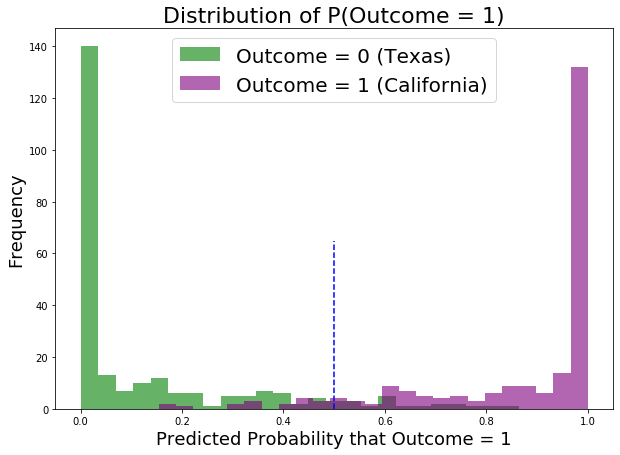

In [107]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='green',
         alpha = 0.6,
         label='Outcome = 0 (Texas)')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='purple',
         alpha = 0.6,
         label='Outcome = 1 (California)')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='blue',
           linestyle = '--')

# Create legend.
plt.legend(fontsize=20);